# System with Two Catenary lines

We first install the necessary packages

In [37]:
pip install numpy

Note: you may need to restart the kernel to use updated packages.


In [38]:
pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [39]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [40]:
import numpy as np
import math as math
from scipy import optimize
import matplotlib.pylab as plt
from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
pass

## Define properties of the lines

- Keeping all variables in SI Units (kg, m, s) and force in N
- Assuming both lines have the same properties.
- A new quantity, anch_sep, to define the distance between the two anchors.

In [41]:
g = 9.81 #m/s2
W1_pm = 376 #kg/m
EA1 = 1850000000 #N
L1_tot = 400 #m

W2_pm = 376 #kg/m
EA2 = 1850000000 #N
L2_tot = 410 #m

d0 = 85 #m still-water depth

anch_sep = 743. #m
moor_sep = 30 #m

x1_anch = 0
x2_anch = anch_sep-x1_anch

## Define all functions

We carry forward the functions from the previous notebook.

In [42]:
def catenary_end_xz(W_pm, L_tot, EA, V_AN, H_AN, L_susp):
    
    W = W_pm*L_susp*g
        
    s = L_susp    
    z_t1 = 1 + (V_AN/H_AN)**2
    z_t2 = 1 + ((V_AN - W*s/L_susp)/H_AN)**2
    z = W*s/EA * (s/2/L_susp - V_AN/W) - H_AN*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))            
    x_susp = H_AN*s/EA + H_AN*L_susp/W*(np.arcsinh(V_AN/H_AN) - np.arcsinh((V_AN - W*s/L_susp)/H_AN))
    x_bed = L_tot - L_susp
    x = x_bed + x_susp
        
    return x, z

In [43]:
def catenary_xz(W_pm, L_tot, EA, V_AN, H_AN, L_susp, ds):
        
    W = W_pm * L_susp * g
    
    # c_s = [0]
    # c_x = [L_tot - L_susp]
    # c_z = [0]
    # c_H = [H_AN]
    # c_V = [V_AN]
    
    c_s = [0, 0]    
    c_x = [0, L_tot - L_susp]
    c_z = [0, 0]
    c_H = [H_AN, H_AN]
    c_V = [V_AN, V_AN]
    
    Ns = math.floor(L_susp/ds)
    ds = L_susp/Ns
    for i in range(1,Ns+1):
        s = c_s[-1]+ds        
        z_t1 = 1 + (V_AN/H_AN)**2
        z_t2 = 1 + ((V_AN - W*s/L_susp)/H_AN)**2
        z = W*s/EA * (s/2/L_susp-V_AN/W) - H_AN*L_susp/W*(np.sqrt(z_t1) - np.sqrt(z_t2))        
        x_susp = H_AN*s/EA + H_AN*L_susp/W*(np.arcsinh(V_AN/H_AN) - np.arcsinh((V_AN - W*s/L_susp)/H_AN))        
        V = V_AN + W_pm*s*g
        x = L_tot - L_susp + x_susp
        
        c_s.append(s)        
        c_x.append( x )
        c_z.append( z )        
        c_V.append( V )
        
    print(c_s[-1], c_x[-1], c_z[-1], c_V[-1])
        
    return c_s, c_x, c_z, c_V

In [44]:
def objective_fnc(sol, *data):        
    H_AN = sol[0]
    L = sol[1] #suspended length
    W_pm, L_tot, EA, V_AN, xtarg, ztarg  = data
    x, z = catenary_end_xz(W_pm, L_tot, EA, V_AN, H_AN, L)    
    return np.array( [abs(ztarg-z),  abs(xtarg-x)] )

## Initial position

- For the given problem, both lines have the same properties.
- The target position is specified by x0,z0, indicating the centre of the body.
    - => x0_targ, z0_targ = (350, d0)


In [45]:
x0_targ, z0_targ = (anch_sep/2, d0)

x1_targ, z1_targ = (x0_targ - moor_sep/2.0, d0)
data1 = (W1_pm, L1_tot, EA1, 0, x1_targ, z1_targ)
H1, L1_susp = optimize.fsolve(objective_fnc,np.array([10,10]),args=data1)

x2_targ, z2_targ = (anch_sep - moor_sep - x1_targ, d0)
data2 = (W2_pm, L2_tot, EA2, 0, x2_targ, z2_targ)
H2, L2_susp = optimize.fsolve(objective_fnc,np.array([10,10]),args=data2)

print(H1, L1_susp)
print(H2, L2_susp)
print("Net Horizontal Force = ",(H2-H1)/1000)
print("x1_moor, x2_moor = ",x1_targ, anch_sep-x2_targ-moor_sep)

176681.3547641955 123.9511932107845
89474.98972527622 106.51897357774943
Net Horizontal Force =  -87.20636503891929
x1_moor, x2_moor =  356.5 356.5


Plotting the two lines

123.95119321078198 356.49999999999915 84.99999999999764 457201.41322956205
106.51897357775007 356.5000000000002 85.0000000000006 392901.62517994584
176681.3547641955 89474.98972527622
-87.20636503891929


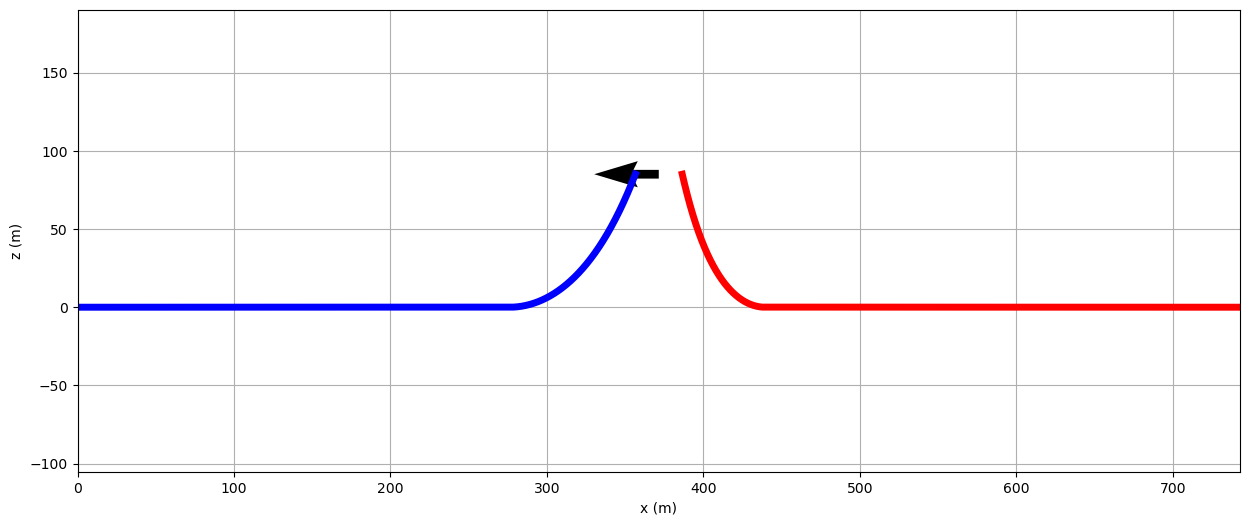

In [46]:
l1_s, l1_x, l1_z, l1_V = catenary_xz(W1_pm, L1_tot, EA1, 0, H1, L1_susp, 0.1)
l2_s, l2_x, l2_z, l2_V = catenary_xz(W2_pm, L2_tot, EA2, 0, H2, L2_susp, 0.1)

plt.figure()
plt.plot(l1_x, l1_z, 'b-', lw=5)
plt.plot([anch_sep-x for x in l2_x], l2_z, 'r-', lw=5)
plt.quiver(x0_targ, z0_targ, H2-H1, 0)
plt.axis("equal")
plt.grid("on")
plt.xlabel('x (m)')
plt.ylabel('z (m)')
plt.xlim(left=0, right=anch_sep)
print(H1,H2)
print((H2-H1)/1000)
plt.show()
pass

## Force-excursion diagram

- We calculate the force excursion diagram for the system
- The x1_targ will be varied between two intervals to calculate the net horizontal force on the body.

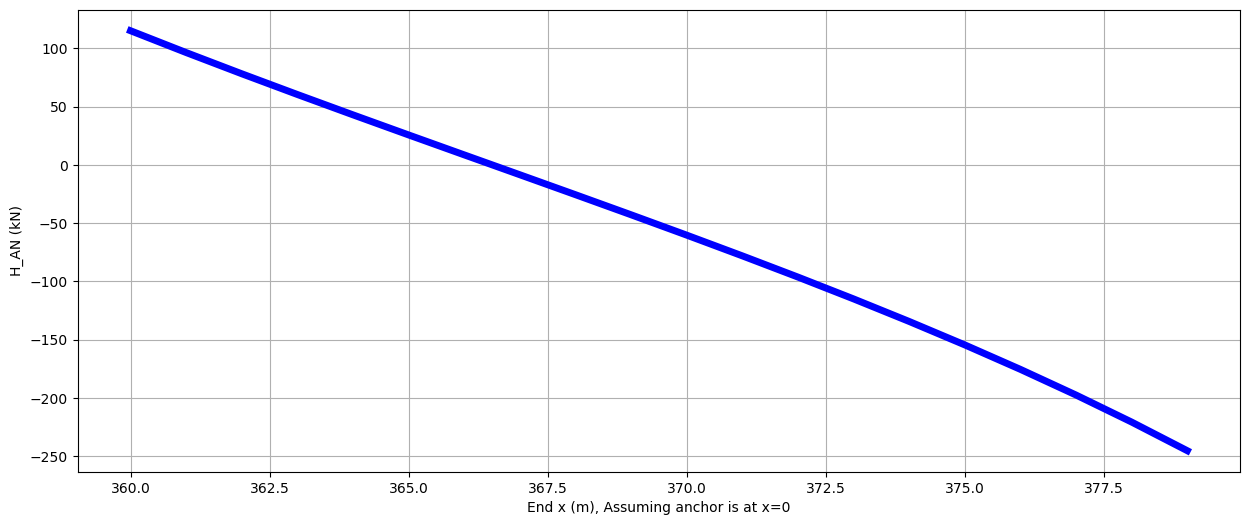

In [47]:
x0_targ_array = np.arange(360,380)
x1_targ_array = [x - moor_sep/2 for x in x0_targ_array]
x2_targ_array = [anch_sep - moor_sep - x for x in x1_targ_array]

sol1_array = [optimize.fsolve(objective_fnc,
                             np.array([10,10]),
                             args=(W1_pm, L1_tot, EA1, 0, lx, z1_targ)) 
              for lx in x1_targ_array]
sol2_array = [optimize.fsolve(objective_fnc,
                             np.array([10,10]),
                             args=(W2_pm, L2_tot, EA2, 0, lx, z2_targ)) 
              for lx in x2_targ_array]

H1_array = [sol[0] for sol in sol1_array]
H2_array = [sol[0] for sol in sol2_array]

plt.figure()
plt.plot( x0_targ_array, 
         [(H2l-H1l)/1000 for H1l,H2l in zip(H1_array,H2_array)], 'b-', lw=5)
plt.grid("on")
plt.xlabel('End x (m), Assuming anchor is at x=0')
plt.ylabel('H_AN (kN)')
#plt.xlim(left=549, right=551)
#plt.ylim(bottom=2350, top=2450)
plt.show()
pass